In [1]:
import math
import numpy as np
import hypertools as hyp
import pycircstat
from os.path import join as opj
from statsmodels.stats.multitest import multipletests as mt
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

cmap = plt.cm.Spectral
%matplotlib inline

### Define some custom functions/classes

In [2]:
class Point:
    def __init__(self, coord=None):
        self.coord = np.array(coord)
        
class LineSegment:  
    def __init__(self, p1=None, p2=None):
        if isinstance(p1, Point):
            self.p1 = p1
        else:
            self.p1 = Point(p1)
            
        if isinstance(p2, Point):
            self.p2 = p2
        else:
            self.p2 = Point(p2)
        
    def intersect(self, z):
        if isinstance(z, Circle):
            return _seg_intersect_circle(self, z)
        elif isinstance(x, Rectangle):
            return _seg_intersect_rect(self, z)
        
    def norm(self):
        diff = self.p2.coord-self.p1.coord
        return diff/np.linalg.norm(diff)
    
    def get_p1(self):
        return self.p1.coord
    
    def get_p2(self):
        return self.p2.coord
    
    def get_vec(self):
        return self.p2.coord-self.p1.coord
        
    def angle(self, ref=None):
        if ref==None:
            p1 = np.zeros_like(self.get_p1())
            p2 = np.zeros_like(self.get_p1())
            p2[0] = 1
            ref = LineSegment(p1, p2)
        v0 = ref.get_vec()
        v1 = self.get_vec()
        return np.arccos(v0.dot(v1)/(np.linalg.norm(v0)*np.linalg.norm(v1)))
        
class Circle:
    def __init__(self, center=None, r=None):
        self.center = np.array(center)
        self.r = r 
    
    def get_center(self):
        return self.center
    
    def get_radius(self):
        return self.r
        
class Rectangle:
    def __init__(self, x=None, y=None, w=None):
        self.c0 = x-w
        self.c1 = y-w
        self.c2 = x+w
        self.c3 = y+w
    
def _seg_intersect_circle(ls, circ):
     
    Q = circ.get_center()
    r = circ.get_radius()
    P1 = ls.get_p1()
    V = ls.get_p2() - P1
    
    a = V.dot(V)
    b = 2 * V.dot(P1 - Q)
    c = P1.dot(P1) + Q.dot(Q) - 2 * P1.dot(Q) - r**2
    
    disc = b**2 - 4 * a * c
    if disc < 0:
        return False
    
    sqrt_disc = math.sqrt(disc)
    t1 = (-b + sqrt_disc) / (2 * a)
    t2 = (-b - sqrt_disc) / (2 * a)
    if not (0 <= t1 <= 1 or 0 <= t2 <= 1):
        return False
    
    return True
    
def _seg_intersect_rect(ls, r):
    
    # find min/max X for the segment
    minX = min(ls.p1.x, ls.p2.x)
    maxX = max(ls.p1.x, ls.p2.x)
    
    # find the intersection of the segment's and rectangle's x-projections
    if maxX > r.c2:
        maxX = r.c2
    if minX < r.c0:
        minX = r.c0
    
    if minX > maxX:
        return False
    
    minY = ls.p1.y
    maxY = ls.p2.y
    
    dx = ls.p2.x - ls.p1.x
    
    if abs(dx) > .0000001:
        a = (ls.p2.y - ls.p1.y) / dx
        b = ls.p1.y - a * ls.p1.x
        minY = a * minX + b
        maxY = a * maxX + b
        
    if minY > maxY:
        tmp = maxY
        maxY = minY
        minY = tmp
        
    # find the intersection of the segment's and rectangle's y-projections
    if maxY > r.c3:
        maxY = r.c3
    if minY < r.c1:
        minY = r.c1
        
    # if Y-projections do not intersect return false
    if minY > maxY:
        return False
    else:
        return True
    
def add_arrows(axes, x, y, **kwargs):

    # spacing of arrows
    aspace = .05 # good value for scale of 1
    aspace *= scale

    # r is the distance spanned between pairs of points
    r = [0]
    for i in range(1,len(x)):
        dx = x[i]-x[i-1]
        dy = y[i]-y[i-1]
        r.append(np.sqrt(dx*dx+dy*dy))
    r = np.array(r)

    # rtot is a cumulative sum of r, it's used to save time
    rtot = []
    for i in range(len(r)):
        rtot.append(r[0:i].sum())
    rtot.append(r.sum())

    arrowData = [] # will hold tuples of x,y,theta for each arrow
    arrowPos = 0 # current point on walk along data
    rcount = 1 
    while arrowPos < r.sum():
        x1,x2 = x[rcount-1],x[rcount]
        y1,y2 = y[rcount-1],y[rcount]
        da = arrowPos-rtot[rcount] 
        theta = np.arctan2((x2-x1),(y2-y1))
        ax = np.sin(theta)*da+x1
        ay = np.cos(theta)*da+y1
        arrowData.append((ax,ay,theta))
        arrowPos+=aspace
        while arrowPos > rtot[rcount+1]: 
            rcount+=1
            if arrowPos > rtot[-1]:
                break

    # could be done in above block if you want
    for ax,ay,theta in arrowData:
        # use aspace as a guide for size and length of things
        # scaling factors were chosen by experimenting a bit
        axes.arrow(ax,ay,
                   np.sin(theta)*aspace/10,np.cos(theta)*aspace/10, 
                   head_width=aspace/3, **kwargs)

In [3]:
def compute_coord(xi, yi, w, seglist, kind='rectangle'):
    
    if kind=='rectangle':
        z = Rectangle(x=xi, y=yi, w=w)
    elif kind=='circle':
        z = Circle(center=[xi,yi], r=w)
        
    segs = list(filter(lambda s: s.intersect(z), seglist))
    
    if len(segs)>1:
        u, v  = np.array([seg.norm() for seg in segs]).mean(0)
        rads = np.array([seg.angle() for seg in segs])
        p, z = pycircstat.tests.rayleigh(rads)
    else:
        u = 0
        v = 0
        p = 1
    c = len(segs)
    return u, v, p, c

### Set path

In [4]:
datadir = '/mnt/data/processed/'

### Load the data

In [5]:
video_events = np.load(opj(datadir, 'video_events.npy'))
avg_recall_events = np.load(opj(datadir, 'avg_recall_events.npy'))
recall_events = np.load(opj(datadir, 'recall_events.npy'), allow_pickle=True)
mappings = np.load(opj(datadir, 'labels.npy'), allow_pickle=True)

### create 2D embeddings

In [6]:
# np.random.seed(1441)
# embeddings = hyp.reduce(list(recall_events) + [video_events] + [avg_recall_events], reduce='UMAP', ndims=2)
# video_embedding = embeddings[-2]
# recall_embeddings = embeddings[:-2]
# avg_recall_embedding = embeddings[-1]

In [7]:
order = 4
seed = 2202

embeddings = np.load(f'../../../data/order{order}_seed{seed}.npy', allow_pickle=True)

video_embedding, avg_recall_embedding, recall_embeddings = embeddings

### save out embeddings

In [8]:
# np.save(opj(datadir, 'embeddings.npy'), [recall_embeddings, video_embedding, avg_recall_embedding])

### Create a 2D grid

In [9]:
step = .25
scale = 8
X, Y = np.meshgrid(np.arange(-scale, scale, step), np.arange(-scale, scale, step))

### Turn the embedded recall event models into a list of line segments

In [10]:
seglist = []
for sub in recall_embeddings:
    for i in range(sub.shape[0]-1):
        p1 = Point(coord=sub[i, :])
        p2 = Point(coord=sub[i+1, :])
        seg = LineSegment(p1=p1, p2=p2)
        seglist.append(seg)

### filter any video events with no successful recalls from average recall embedding

In [11]:
no_rec_mask = np.all(np.equal(avg_recall_events, 0), axis=1)
avg_recall = avg_recall_embedding[~no_rec_mask]

if ~np.any(no_rec_mask):
    print('All video events recalled at least once')

All video events recalled at least once


### Compute the average vector and p value at each grid point

In [12]:
U = np.zeros_like(X)
V = np.zeros_like(X)
P = np.zeros_like(X)
Z = np.zeros_like(X)
C = np.zeros_like(X)
for i, (x, y) in enumerate(zip(X, Y)):
    for j, (xi, yi) in enumerate(zip(x, y)):
        U[i, j], V[i, j], P[i, j], C[i, j] = compute_coord(xi, yi, step*2, seglist, kind='circle')

## Multiple comparisons correction

In [13]:
thresh = .001
Pc = mt(P.ravel(), method='fdr_bh', alpha=.05)[1].reshape(64,64)
X_sig = X[Pc<thresh]
X_notsig = X[Pc>thresh]
Y_sig = Y[Pc<thresh]
Y_notsig = Y[Pc>thresh]
U_sig = U[Pc<thresh]
U_notsig = U[Pc>thresh]
V_sig = V[Pc<thresh]
V_notsig = V[Pc>thresh]
M = np.hypot(U, V)
M = plt.cm.Blues(M)
M[Pc>thresh]=[.5, .5, .5, .25]
M[Pc==1]=[.5, .5, .5, 0]

### Plot the result

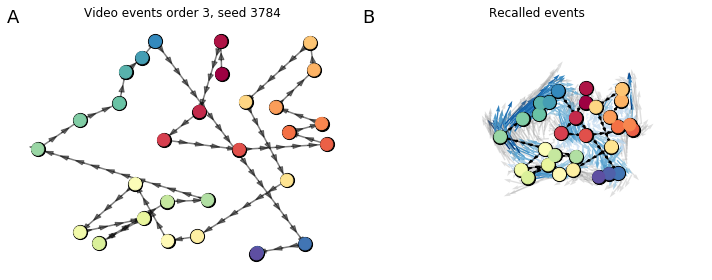

In [14]:
mpl.rcParams['pdf.fonttype'] = 42

fig, axarr = plt.subplots(1, 2, figsize=(10, 4))
axarr[0].scatter(video_embedding[:, 0], video_embedding[:, 1], c=range(video_embedding.shape[0]), cmap=cmap, s=150, zorder=3)
axarr[0].scatter(video_embedding[:, 0], video_embedding[:, 1], c='k', cmap=cmap, s=200, zorder=2)
axarr[0].plot(video_embedding[:, 0], video_embedding[:, 1], zorder=1, c='k', alpha=.5)
add_arrows(axarr[0], video_embedding[:, 0], video_embedding[:, 1], zorder=0, alpha=.5, color='k', fill=True)
axarr[0].axis('off')
axarr[0].set_title(f'Video events order {order}, seed {seed}')
# axarr[0].set_xlim(-7.5, 2.5)
# axarr[0].set_ylim(-5, 4)
axarr[0].text(0, 1,'A',
        horizontalalignment='center',
        transform=axarr[0].transAxes,
          fontsize=18)

axarr[1].quiver(X, Y, U, V, color=M.reshape(M.shape[0]*M.shape[1],4), zorder=1, width=.004)
axarr[1].plot(avg_recall[:, 0], avg_recall[:, 1], zorder=2, c='k', alpha=.5)
add_arrows(axarr[1], avg_recall[:, 0], avg_recall[:, 1], zorder=3, alpha=1, color='k', fill=True)
axarr[1].scatter(avg_recall[:, 0], avg_recall[:, 1], c=range(avg_recall.shape[0]), cmap=cmap, s=150, zorder=4)
axarr[1].scatter(avg_recall[:, 0], avg_recall[:, 1], c='k', cmap=cmap, s=200, zorder=3)
axarr[1].axis('off')
axarr[1].set_title('Recalled events')
# axarr[1].set_xlim(-7.5, 2.5)
# axarr[1].set_ylim(-5, 4)
axarr[1].text(0, 1,'B',
        horizontalalignment='center',
        transform=axarr[1].transAxes,
          fontsize=18)

plt.tight_layout()
plt.subplots_adjust(wspace=.05, hspace=.25)
plt.show()

In [15]:
# plt.figure(figsize=(10,8))
# mpl.rcParams['pdf.fonttype'] = 42
# axarr = [0 for i in range(2)]
# axarr[0] = plt.subplot2grid((5, 6), (0, 0), colspan=3, rowspan=2)
# axarr[1] = plt.subplot2grid((5, 6), (0, 3), colspan=3, rowspan=2)
# for i in range(2, 5):
#     for j in range(0, 6):
#         ax = plt.subplot2grid((5, 6), (i, j))
#         axarr.append(ax)

# # fig, axarr = plt.subplots(1, 2, figsize=(10, 4))
# axarr[0].scatter(video_embedding[:, 0], video_embedding[:, 1], c=range(video_embedding.shape[0]), cmap=cmap, s=150, zorder=3)
# axarr[0].scatter(video_embedding[:, 0], video_embedding[:, 1], c='k', cmap=cmap, s=200, zorder=2)
# axarr[0].plot(video_embedding[:, 0], video_embedding[:, 1], zorder=1, c='k', alpha=.5)
# add_arrows(axarr[0], video_embedding[:, 0], video_embedding[:, 1], zorder=0, alpha=.5, color='k', fill=True)
# axarr[0].axis('off')
# axarr[0].set_title('Video events')
# # axarr[0].set_xlim(-7.5, 2.5)
# # axarr[0].set_ylim(-5, 4)
# axarr[0].text(0, 1,'A',
#         horizontalalignment='center',
#         transform=axarr[0].transAxes,
#           fontsize=18)

# axarr[1].quiver(X, Y, U, V, color=M.reshape(M.shape[0]*M.shape[1],4), zorder=1, width=.004)
# axarr[1].plot(avg_recall[:, 0], avg_recall[:, 1], zorder=2, c='k', alpha=.5)
# add_arrows(axarr[1], avg_recall[:, 0], avg_recall[:, 1], zorder=3, alpha=1, color='k', fill=True)
# axarr[1].scatter(avg_recall[:, 0], avg_recall[:, 1], c=range(avg_recall.shape[0]), cmap=cmap, s=150, zorder=4)
# axarr[1].scatter(avg_recall[:, 0], avg_recall[:, 1], c='k', cmap=cmap, s=200, zorder=3)
# axarr[1].axis('off')
# axarr[1].set_title('Recalled events')
# # axarr[1].set_xlim(-7.5, 2.5)
# # axarr[1].set_ylim(-5, 4)
# axarr[1].text(0, 1,'B',
#         horizontalalignment='center',
#         transform=axarr[1].transAxes,
#           fontsize=18)
# axarr[2].text(0, 1.05,'C',
#         horizontalalignment='center',
#         transform=axarr[2].transAxes,
#           fontsize=18)

# for i, (e, m) in enumerate(zip(embeddings[:-2], mappings)):
#     axarr[i+2].scatter(e[:,0], e[:,1], c=cmap(m/video_embedding.shape[0]), cmap=cmap, s=100, zorder=2)
#     axarr[i+2].plot(e[:,0], e[:,1], zorder=1, c='k', alpha=.25)
#     add_arrows(axarr[i+2], e[:,0], e[:,1], zorder=1, alpha=.25, color='k', fill=True)
#     axarr[i+2].plot(video_embedding[:, 0], video_embedding[:, 1], c='k', zorder=3)
#     axarr[i+2].axis('off')
# #     axarr[i+2].set_xlim(-7.5, 2.5)
# #     axarr[i+2].set_ylim(-5, 4)
#     axarr[i+2].set_title('P%s' % str(i+1))
# axarr[i+3].axis('off')
# plt.tight_layout()
# plt.subplots_adjust(wspace=.05, hspace=.25)
# plt.show()

In [7]:
import os

In [17]:
opts = {'_'.join(x[:2]) for x in [f.split('_') for f in os.listdir('../../../data/optimized/') if f.endswith('.npy')]}

In [31]:
for i in sorted(opts):
    print(i)

order1_seed2229
order1_seed2582
order1_seed5130
order1_seed6117
order1_seed6552
order2_seed9244
order2_seed9487
order3_seed188
order3_seed3261
order3_seed4166
order3_seed49
order3_seed802
order4_seed1887
order4_seed2202
order4_seed2767
order4_seed7848
order4_seed9738
order5_seed3108
order5_seed4820
order5_seed5250
order5_seed5448
order5_seed5894
order5_seed7799
order5_seed7872
order5_seed8046
order5_seed8646
order6_seed1901
order6_seed237
order6_seed3575
order6_seed4654
order6_seed865


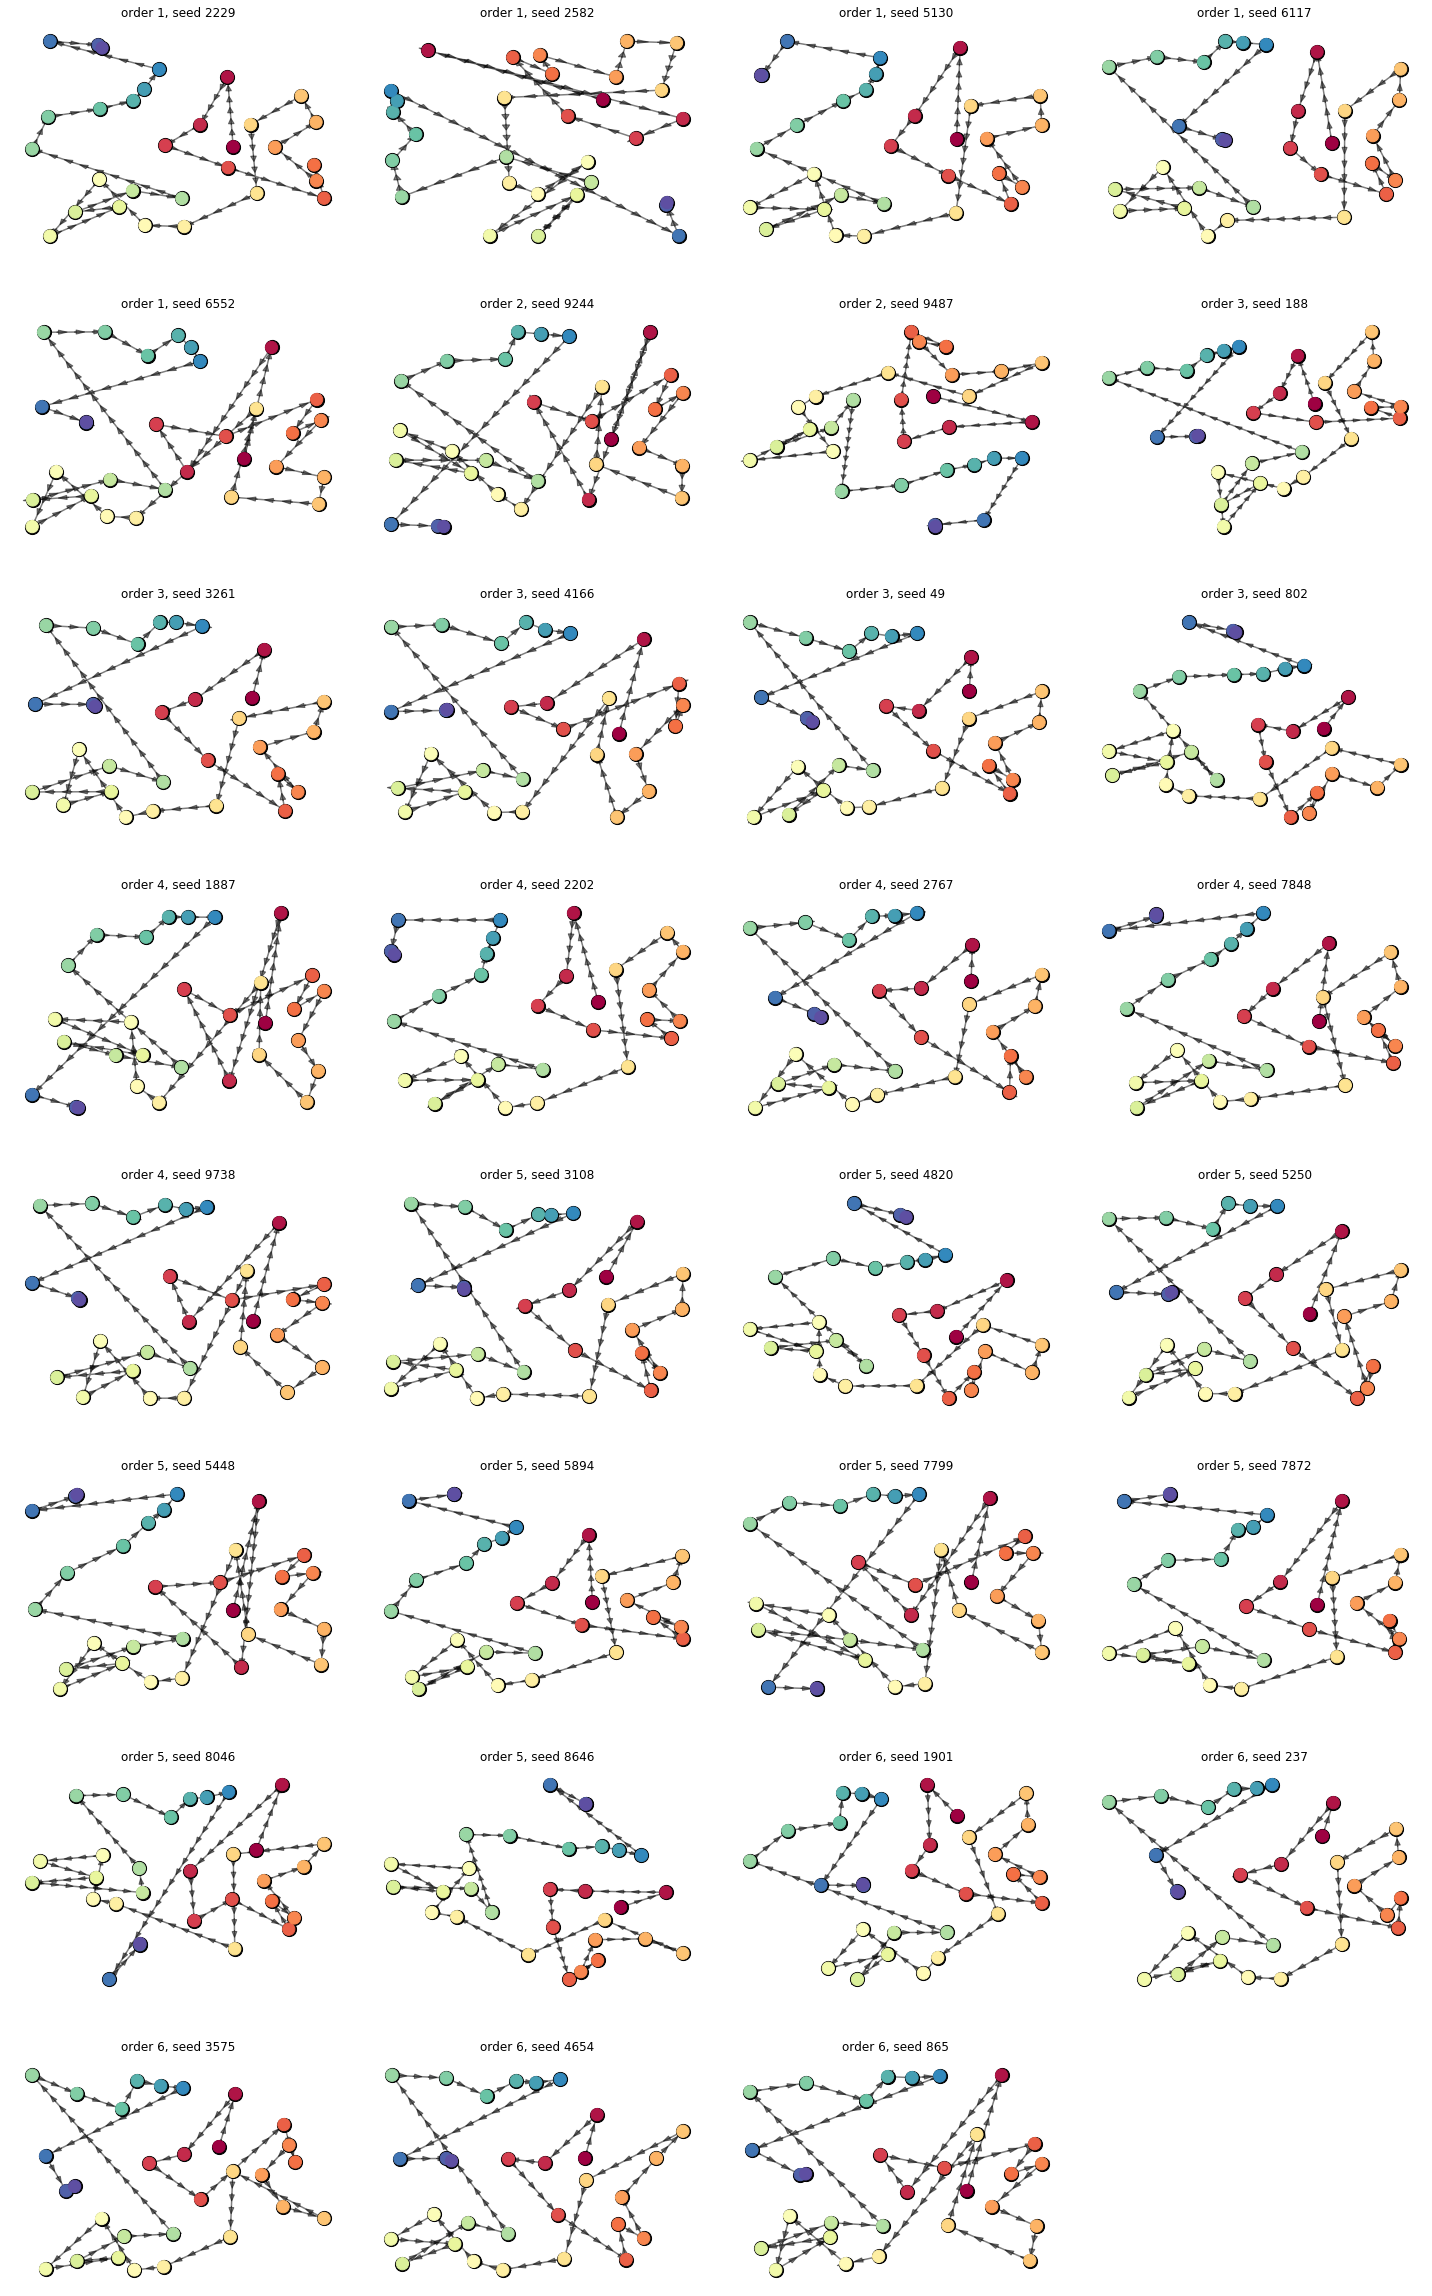

In [34]:
optimized_dir = '../../../data/optimized/'
fig, axarr = plt.subplots(8, 4, figsize=(20, 32))
axarr = axarr.flatten()

for opt, ax in zip(sorted(opts), axarr):
    order = opt.split('_')[0][-1]
    seed = opt.split('_')[1][4:]
    fpath = opj(optimized_dir, [f for f in os.listdir(optimized_dir) if f.startswith(opt)][0])
    video_embedding = np.load(fpath, allow_pickle=True)[0]
    ax.scatter(video_embedding[:, 0], video_embedding[:, 1], c=range(video_embedding.shape[0]), cmap=cmap, s=150, zorder=3)
    ax.scatter(video_embedding[:, 0], video_embedding[:, 1], c='k', cmap=cmap, s=200, zorder=2)
    ax.plot(video_embedding[:, 0], video_embedding[:, 1], zorder=1, c='k', alpha=.5)
    add_arrows(ax, video_embedding[:, 0], video_embedding[:, 1], zorder=0, alpha=.5, color='k', fill=True)
    ax.axis('off')
    ax.set_title(f'order {order}, seed {seed}')
    
axarr[-1].axis('off')
plt.tight_layout()
plt.subplots_adjust(wspace=.05, hspace=.25)
plt.savefig('/mnt/embeddings.pdf')
plt.show()

order1 seed6117 dispersion0.5-intersections0.5


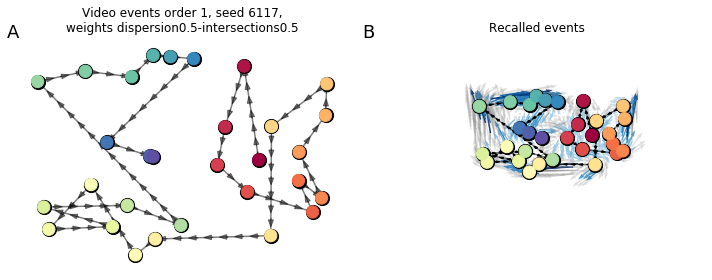

order4 seed7848 dispersion0.75-intersections0.25


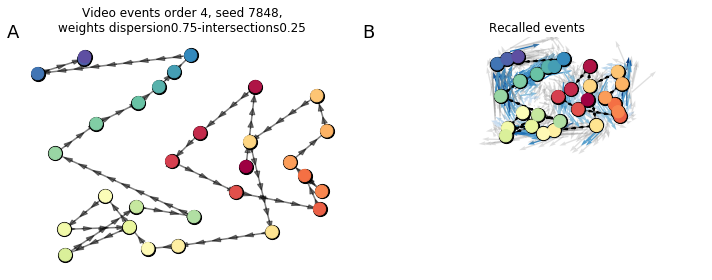

order5 seed3108 dispersion0.75-intersections0.25


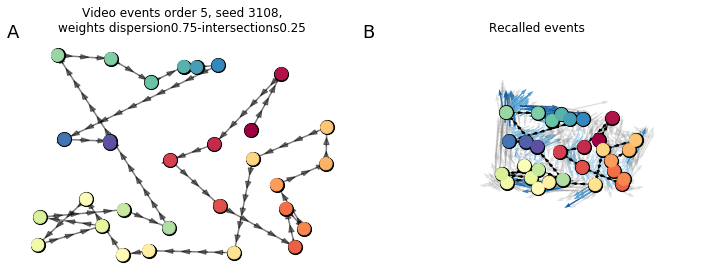

order3 seed49 dispersion0.25-intersections0.75


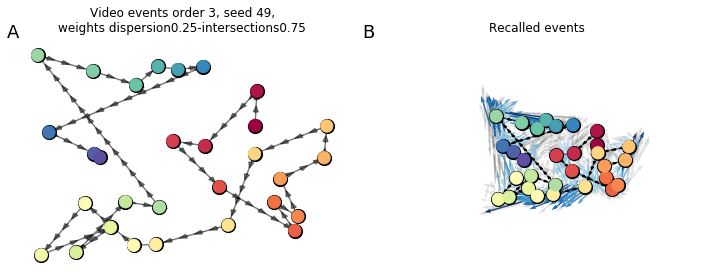

order4 seed9738 dispersion1


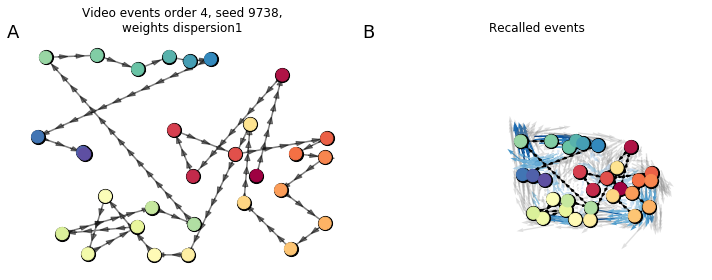

order3 seed3261 dispersion1


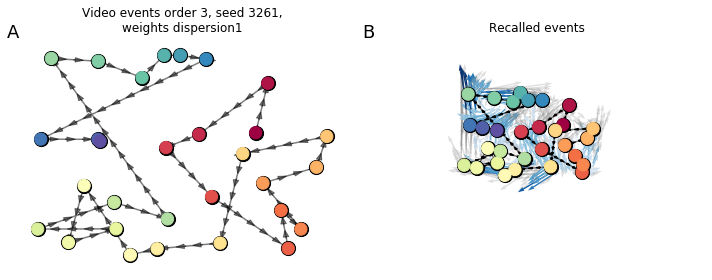

order5 seed5448 dispersion1


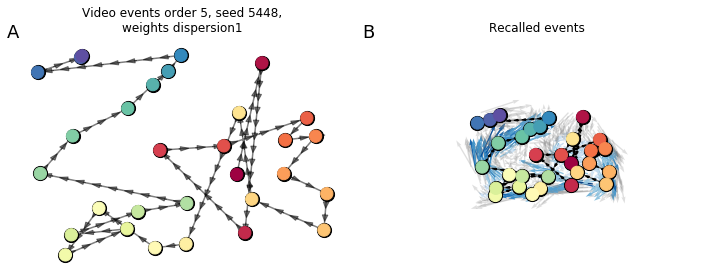

order3 seed49 dispersion0.5-intersections0.5


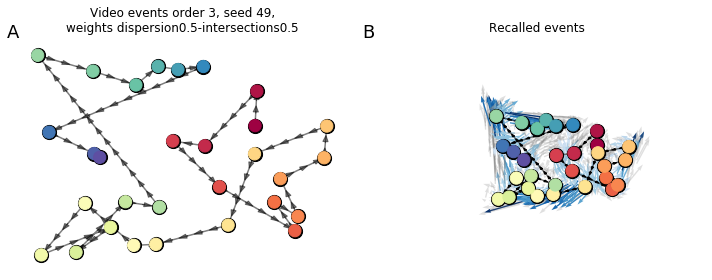

order6 seed237 dispersion0.5-intersections0.5


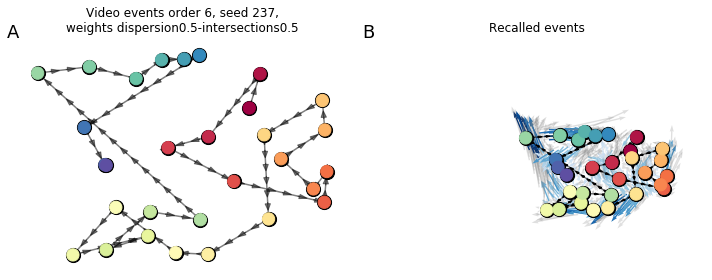

order6 seed3575 dispersion0.25-intersections0.75


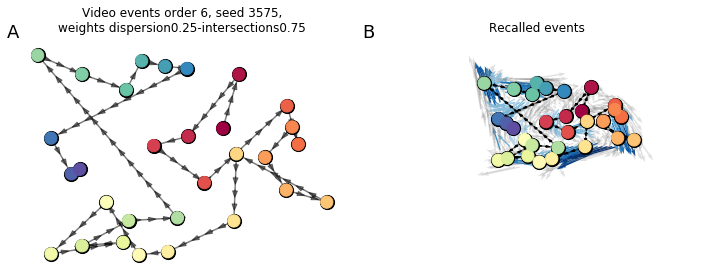

order6 seed865 dispersion1


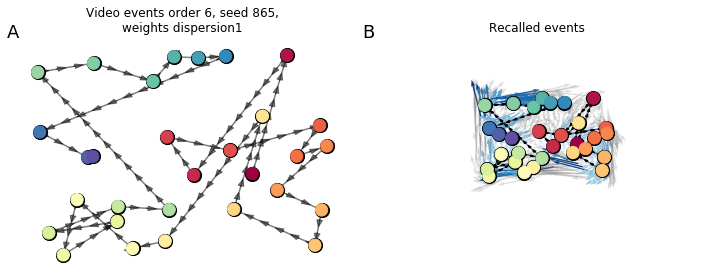

order1 seed5130 dispersion0.75-intersections0.25


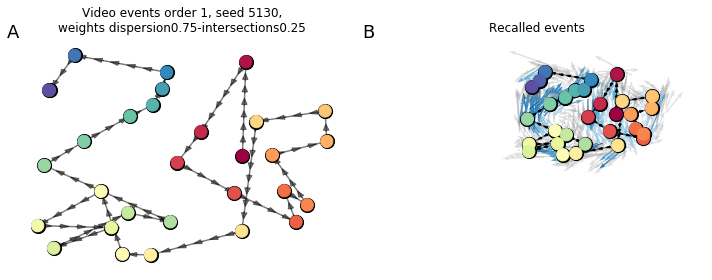

order6 seed1901 intersections1


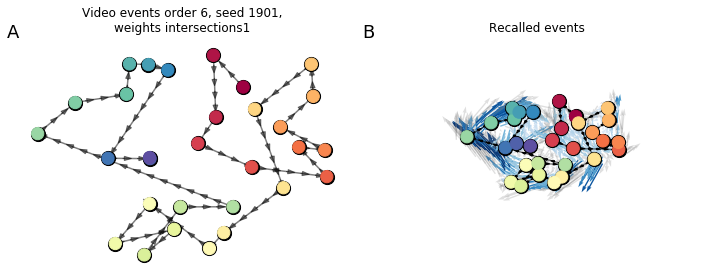

order6 seed4654 dispersion0.25-intersections0.75


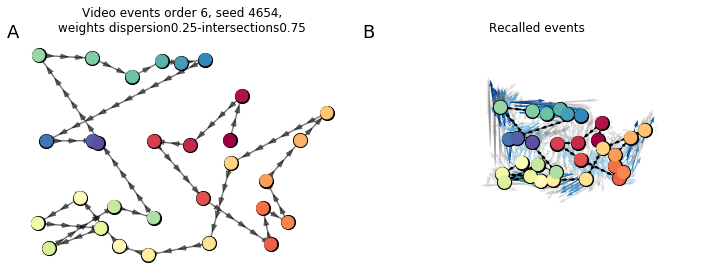

order1 seed2229 intersections1


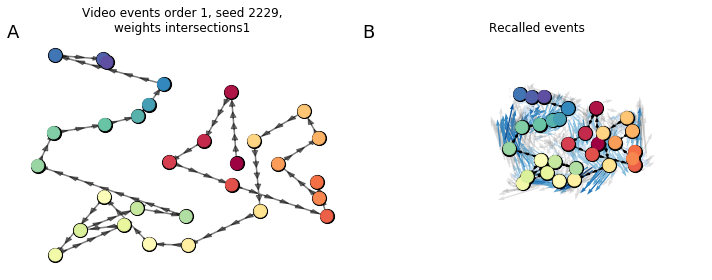

order4 seed2202 dispersion0.75-intersections0.25


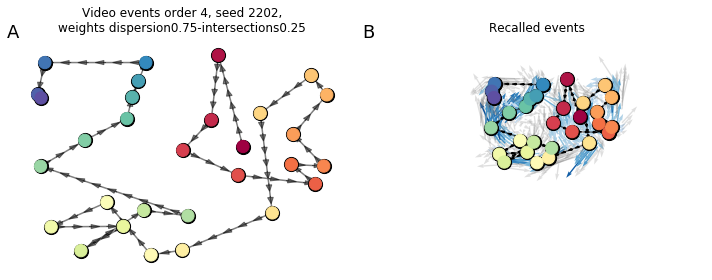

order5 seed7872 dispersion0.75-intersections0.25


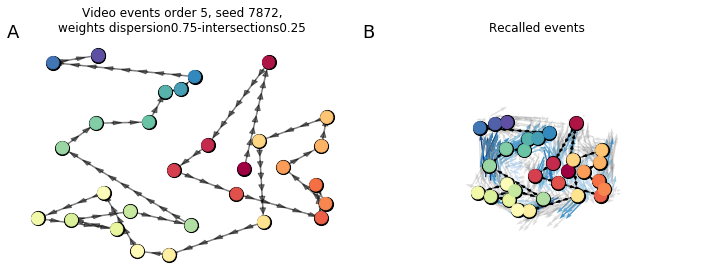

order6 seed237 dispersion0.25-intersections0.75


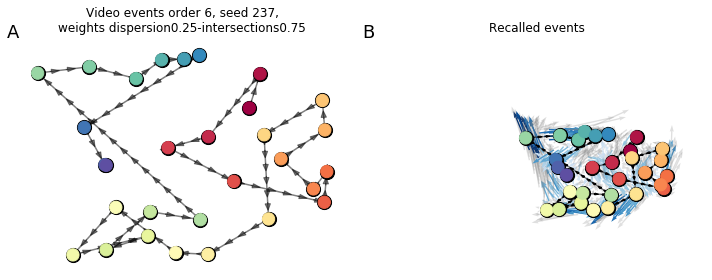

order5 seed8046 intersections1


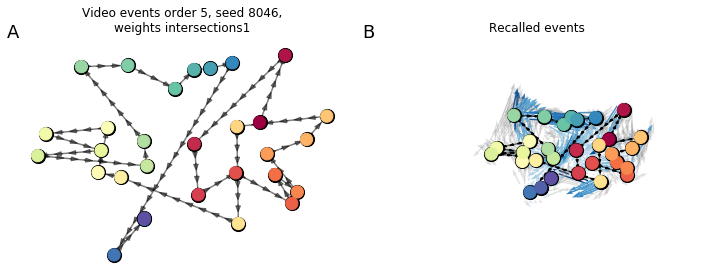

order1 seed6117 dispersion0.75-intersections0.25


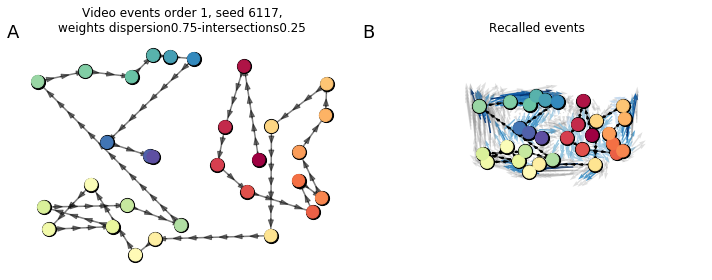

order4 seed2767 dispersion0.25-intersections0.75


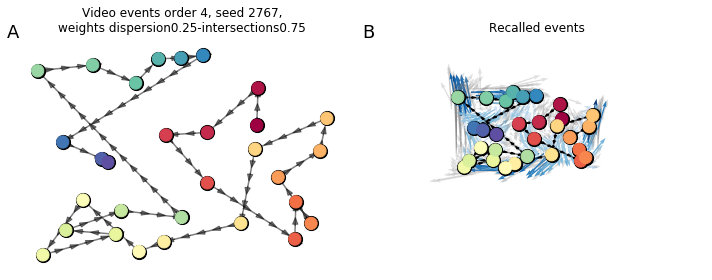

order5 seed7799 dispersion1


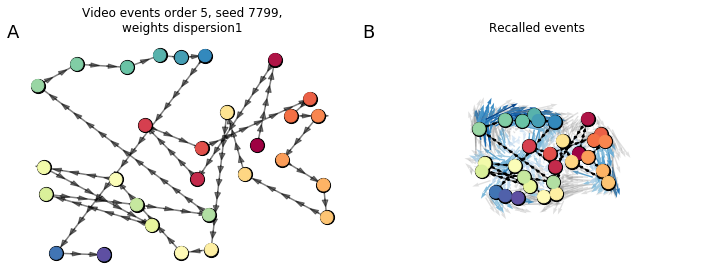

order4 seed7848 dispersion0.5-intersections0.5


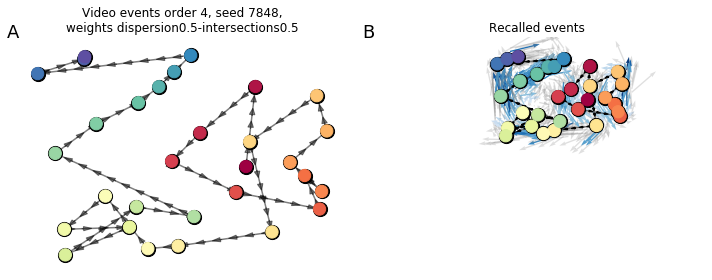

order2 seed9487 intersections1


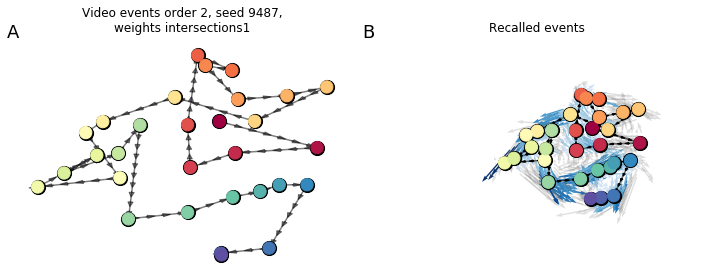

order4 seed2767 dispersion0.75-intersections0.25


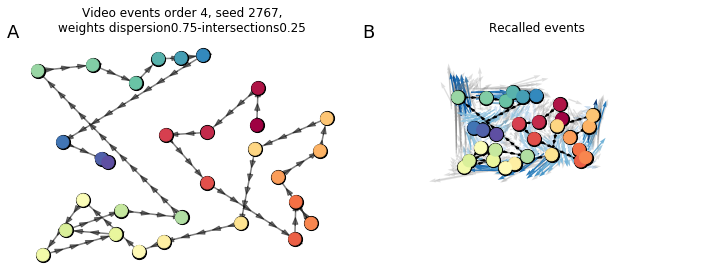

order2 seed9244 dispersion1


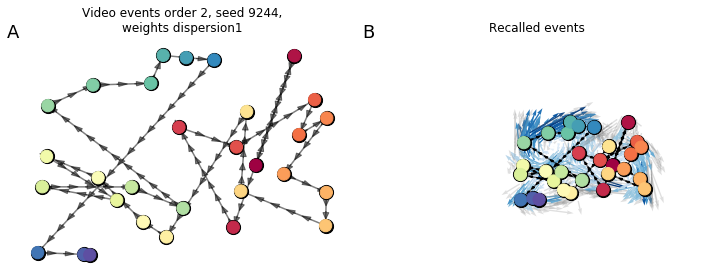

order5 seed3108 dispersion0.5-intersections0.5


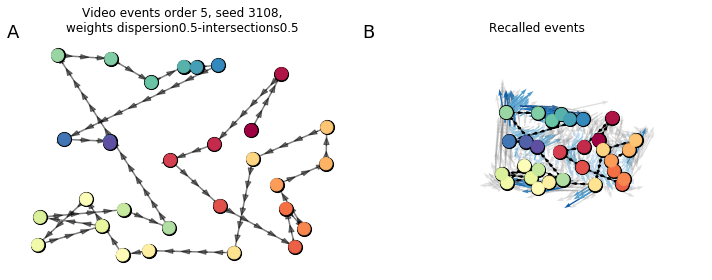

order5 seed7872 intersections1


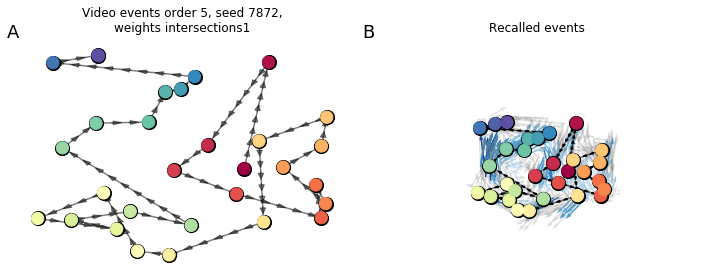

order1 seed6117 dispersion0.25-intersections0.75


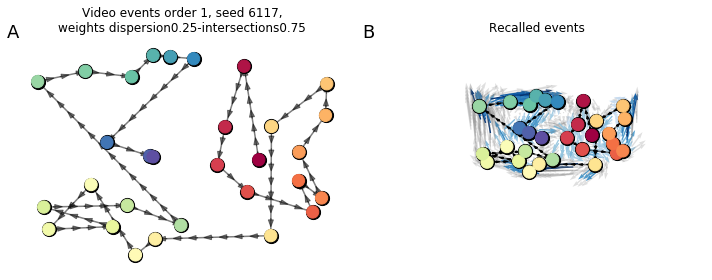

order5 seed8646 intersections1


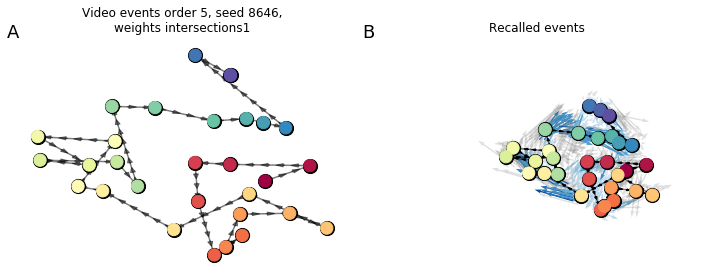

order3 seed802 intersections1


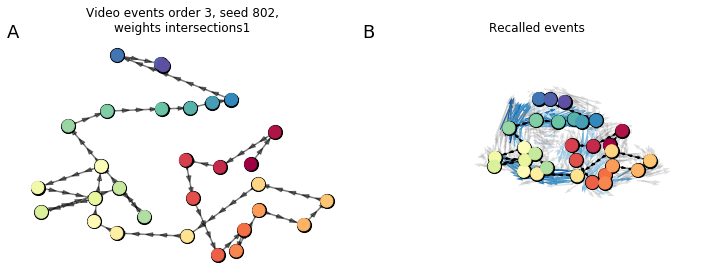

order4 seed2202 dispersion0.25-intersections0.75


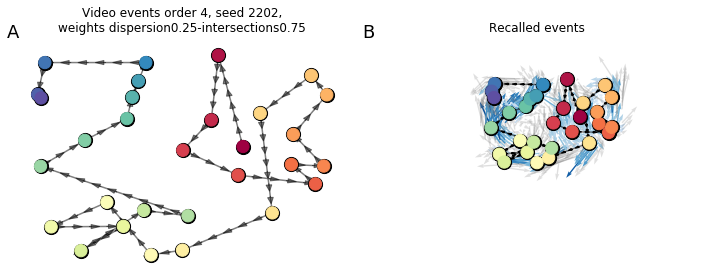

order5 seed7872 dispersion0.25-intersections0.75


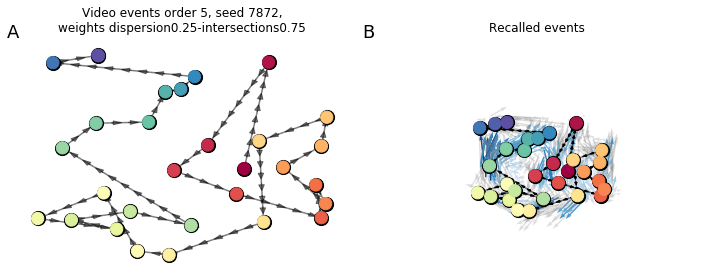

order6 seed237 dispersion0.75-intersections0.25


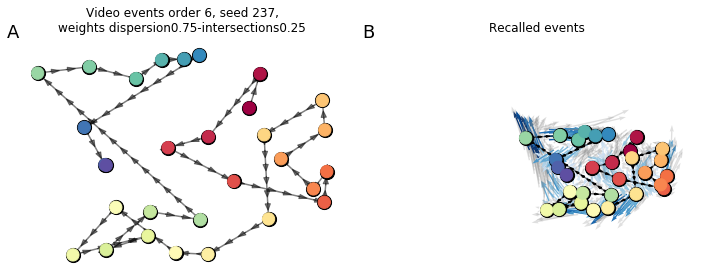

order1 seed6552 dispersion1


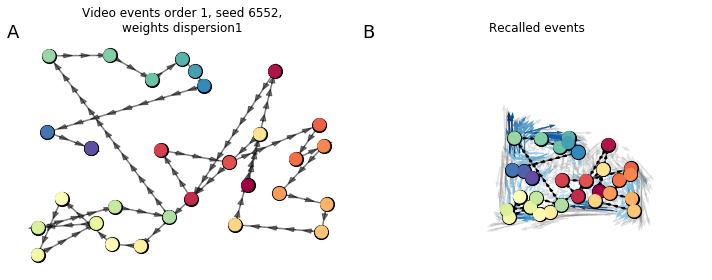

order5 seed7872 dispersion0.5-intersections0.5


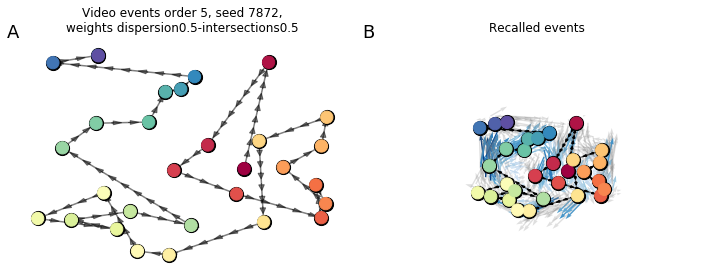

order5 seed5894 intersections1


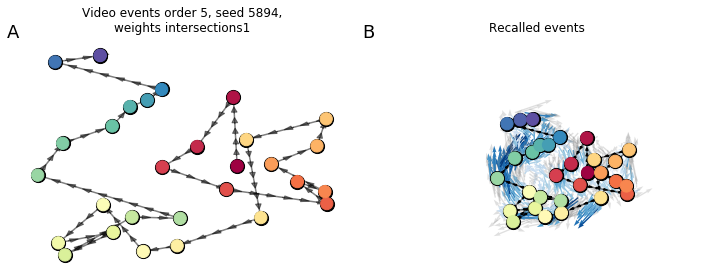

order6 seed4654 dispersion0.75-intersections0.25


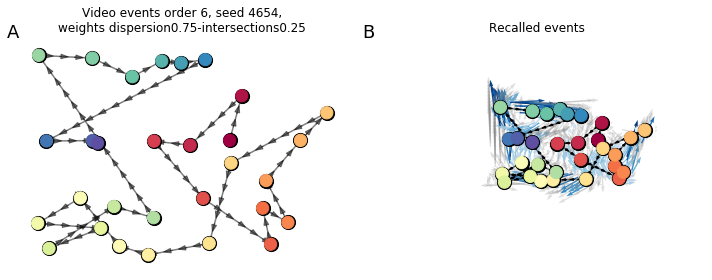

order3 seed188 intersections1


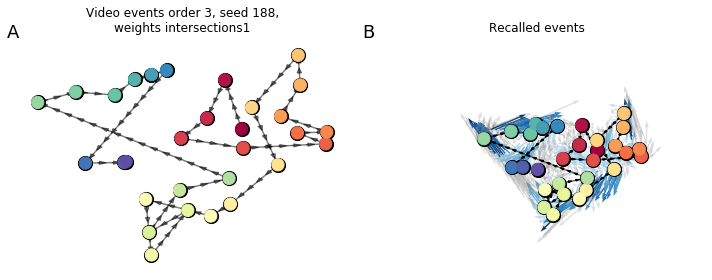

order4 seed2202 dispersion0.5-intersections0.5


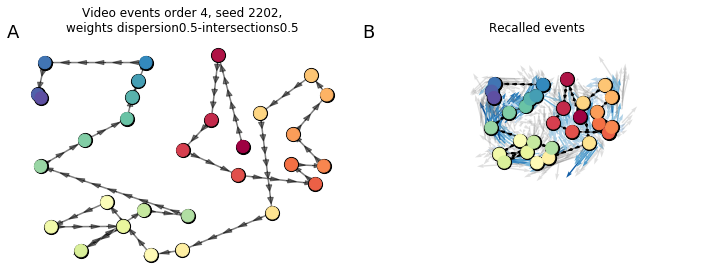

order1 seed5130 dispersion0.25-intersections0.75


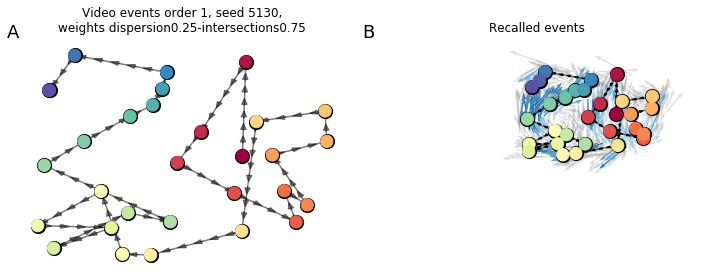

order1 seed2582 dispersion1


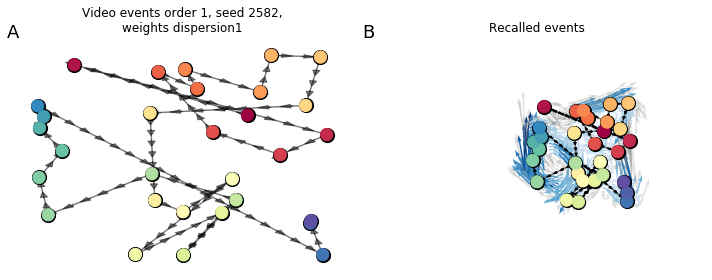

order4 seed1887 dispersion1


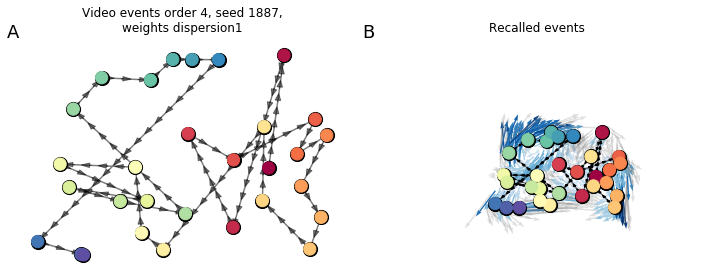

order5 seed5250 dispersion0.75-intersections0.25


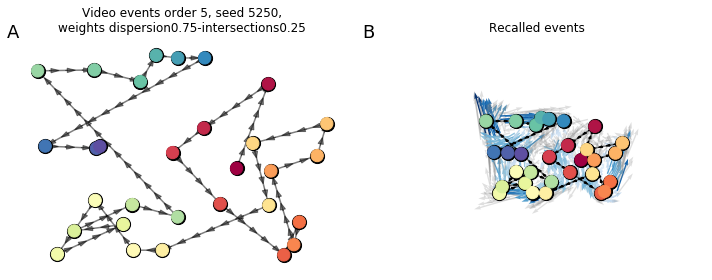

order3 seed4166 dispersion1


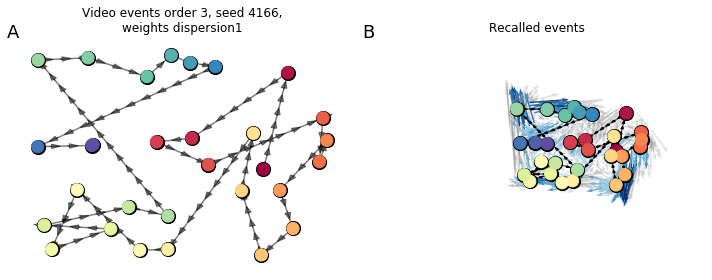

order5 seed4820 intersections1


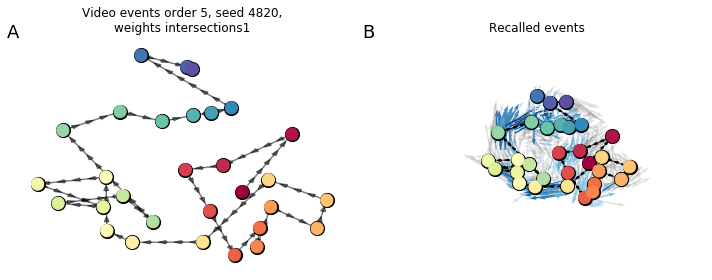

order1 seed5130 dispersion0.5-intersections0.5


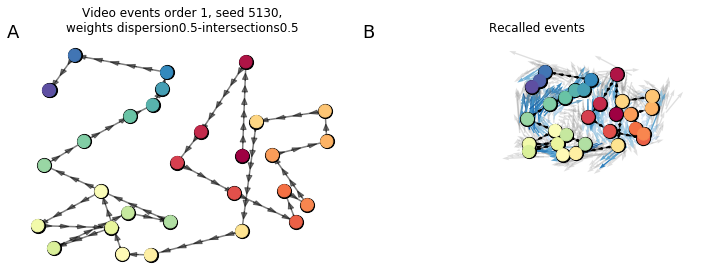

order6 seed4654 dispersion0.5-intersections0.5


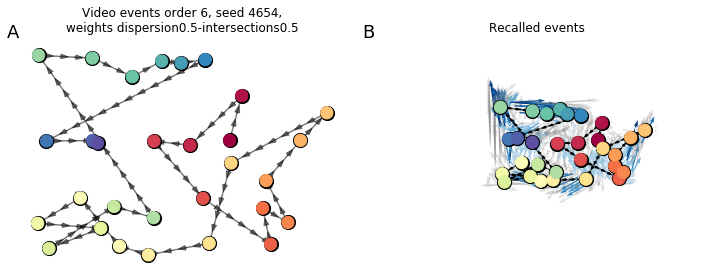

order4 seed2767 dispersion0.5-intersections0.5


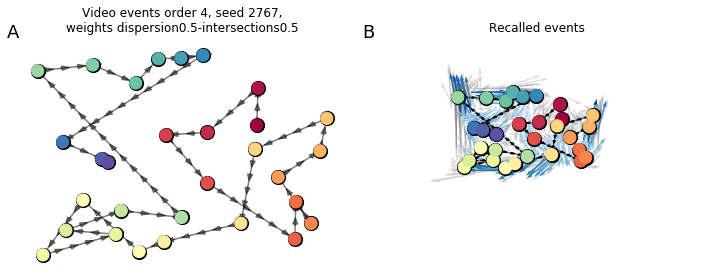

order4 seed7848 dispersion0.25-intersections0.75


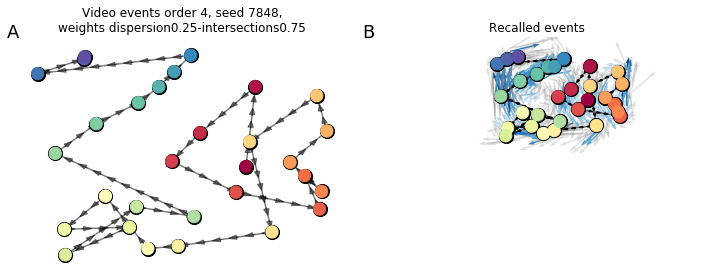

In [8]:
opt_embs = [f for f in os.listdir('../../../data/optimized/') if f.endswith('.npy')]


for opt_emb in opt_embs:
    o, s, suffix = os.path.splitext(opt_emb)[0].split('_')
    order = int(o.lstrip('order'))
    seed = int(s.lstrip('seed'))

    print(o, s, suffix)
    embeddings = np.load(f'../../../data/optimized/order{order}_seed{seed}_{suffix}.npy', allow_pickle=True)

    video_embedding, avg_recall_embedding, recall_embeddings = embeddings


    step = .25
    scale = 8
    X, Y = np.meshgrid(np.arange(-scale, scale, step), np.arange(-scale, scale, step))

    seglist = []
    for sub in recall_embeddings:
        for i in range(sub.shape[0]-1):
            p1 = Point(coord=sub[i, :])
            p2 = Point(coord=sub[i+1, :])
            seg = LineSegment(p1=p1, p2=p2)
            seglist.append(seg)

    no_rec_mask = np.all(np.equal(avg_recall_events, 0), axis=1)
    avg_recall = avg_recall_embedding[~no_rec_mask]


    U = np.zeros_like(X)
    V = np.zeros_like(X)
    P = np.zeros_like(X)
    Z = np.zeros_like(X)
    C = np.zeros_like(X)
    for i, (x, y) in enumerate(zip(X, Y)):
        for j, (xi, yi) in enumerate(zip(x, y)):
            U[i, j], V[i, j], P[i, j], C[i, j] = compute_coord(xi, yi, step*2, seglist, kind='circle')


    thresh = .001
    Pc = mt(P.ravel(), method='fdr_bh', alpha=.05)[1].reshape(64,64)
    X_sig = X[Pc<thresh]
    X_notsig = X[Pc>thresh]
    Y_sig = Y[Pc<thresh]
    Y_notsig = Y[Pc>thresh]
    U_sig = U[Pc<thresh]
    U_notsig = U[Pc>thresh]
    V_sig = V[Pc<thresh]
    V_notsig = V[Pc>thresh]
    M = np.hypot(U, V)
    M = plt.cm.Blues(M)
    M[Pc>thresh]=[.5, .5, .5, .25]
    M[Pc==1]=[.5, .5, .5, 0]


    mpl.rcParams['pdf.fonttype'] = 42

    fig, axarr = plt.subplots(1, 2, figsize=(10, 4))
    axarr[0].scatter(video_embedding[:, 0], video_embedding[:, 1], c=range(video_embedding.shape[0]), cmap=cmap, s=150, zorder=3)
    axarr[0].scatter(video_embedding[:, 0], video_embedding[:, 1], c='k', cmap=cmap, s=200, zorder=2)
    axarr[0].plot(video_embedding[:, 0], video_embedding[:, 1], zorder=1, c='k', alpha=.5)
    add_arrows(axarr[0], video_embedding[:, 0], video_embedding[:, 1], zorder=0, alpha=.5, color='k', fill=True)
    axarr[0].axis('off')
    axarr[0].set_title(f'Video events order {order}, seed {seed},\nweights {suffix}')
    # axarr[0].set_xlim(-7.5, 2.5)
    # axarr[0].set_ylim(-5, 4)
    axarr[0].text(0, 1,'A',
            horizontalalignment='center',
            transform=axarr[0].transAxes,
              fontsize=18)

    axarr[1].quiver(X, Y, U, V, color=M.reshape(M.shape[0]*M.shape[1],4), zorder=1, width=.004)
    axarr[1].plot(avg_recall[:, 0], avg_recall[:, 1], zorder=2, c='k', alpha=.5)
    add_arrows(axarr[1], avg_recall[:, 0], avg_recall[:, 1], zorder=3, alpha=1, color='k', fill=True)
    axarr[1].scatter(avg_recall[:, 0], avg_recall[:, 1], c=range(avg_recall.shape[0]), cmap=cmap, s=150, zorder=4)
    axarr[1].scatter(avg_recall[:, 0], avg_recall[:, 1], c='k', cmap=cmap, s=200, zorder=3)
    axarr[1].axis('off')
    axarr[1].set_title('Recalled events')
    # axarr[1].set_xlim(-7.5, 2.5)
    # axarr[1].set_ylim(-5, 4)
    axarr[1].text(0, 1,'B',
            horizontalalignment='center',
            transform=axarr[1].transAxes,
              fontsize=18)

    plt.tight_layout()
    plt.subplots_adjust(wspace=.05, hspace=.25)
    plt.show()

In [30]:
import os, pickle
import numpy as np
import pandas as pd
opt_dir = '../../../data/optimized/'

order_results = {}
for order in [f'order{i}' for i in range(1, 7)]:
    with open(opj(opt_dir, f'order{order}_results.p'), 'rb') as f:
        order_results[order] = pickle.load(f)

In [71]:
def score_embedding(opt_results, metrics=None, weights=None):
    if not metrics:
        metrics = list(opt_results.keys())
    if not weights:
        weights = {m: 1 / len(metrics) for m in metrics}

    assert sum(weights.values()) == 1, 'weights must sum to 1'
    assert metrics == list(weights.keys()), 'you must pass a weight value for each metric considered'

    scores = pd.DataFrame()
    for metric in metrics:
        asc = False if metric == 'intersections' else True
        res = pd.Series(opt_results[metric])
        scores[metric] = res.rank(pct=True, ascending=asc)
    
    weighted = (scores * weights).sum(axis=1)
    return weighted
#     if percentile == -1:
#         optimal_seeds = weighted.idxmax()
#     else:
#         top_perc = weighted.loc[weighted.rank(pct=True) > percentile / 100].index
#         optimal_seeds = top_perc.values

#     return optimal_seeds

In [140]:
SEEDS = list(range(5001))
METRICS = ['dispersion', 'intersections']
WEIGHTS = {
    'dispersion': .5,
    'intersections': .5
}

# METRICS = ['intersections']
# WEIGHTS = {
#     'intersections': 1
# }

In [134]:
orders_scores = pd.DataFrame()
for order, results in order_results.items():
    orders_scores[order] = score_embedding(results, metrics=METRICS, weights=WEIGHTS)
    


In [135]:
orders_scores.stack().nlargest(10).index.values

array([(2229, 'order1'), (2344, 'order2'), (4820, 'order5'),
       (188, 'order3'), (802, 'order3'), (4185, 'order3'),
       (1901, 'order6'), (3294, 'order6'), (3575, 'order6'),
       (4205, 'order6')], dtype=object)

In [154]:
with open('../../../data/optimized/order1_results.p', 'rb') as f:
    x = pickle.load(f)

In [155]:
x

{'dispersion': array([0.70554047, 0.70554047, 0.70554047, ..., 0.70554047, 0.70554047,
        0.70554047]),
 'intersections': array([13., 13., 13., ..., 13., 13., 13.]),
 'similarity_corr': array([0.1258544, 0.1258544, 0.1258544, ..., 0.1258544, 0.1258544,
        0.1258544]),
 'similarity_euc': array([-0.28185059, -0.28185059, -0.28185059, ..., -0.28185059,
        -0.28185059, -0.28185059])}